In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

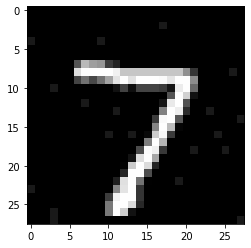

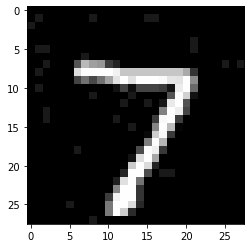

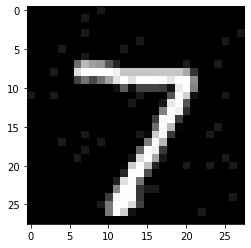

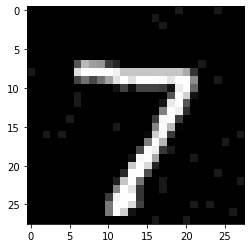

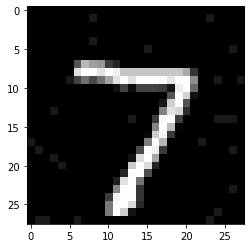

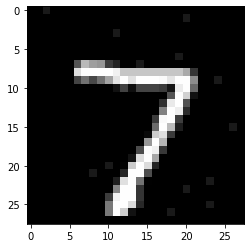

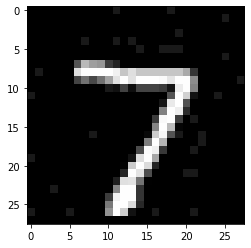

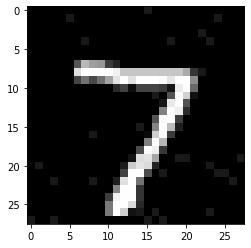

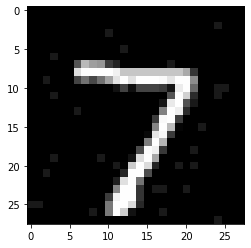

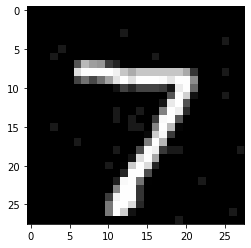

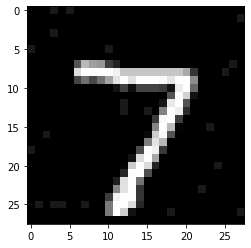

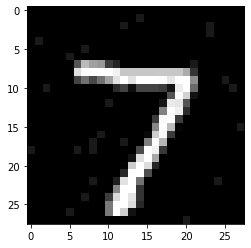

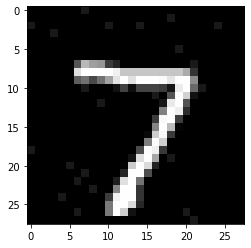

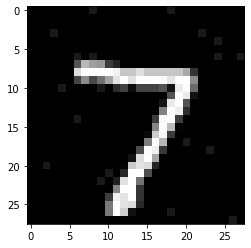

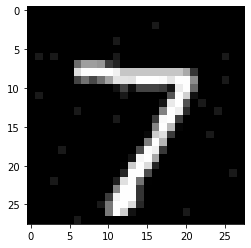

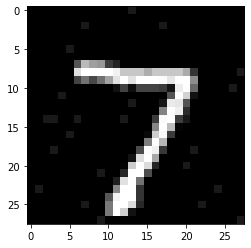

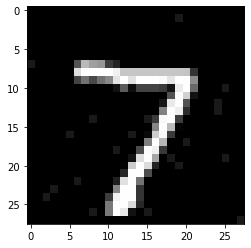

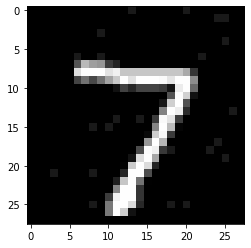

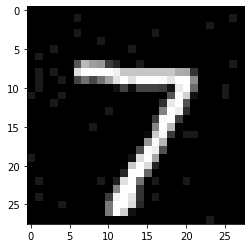

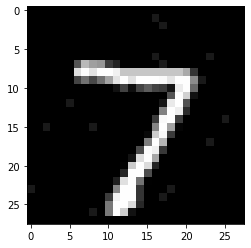

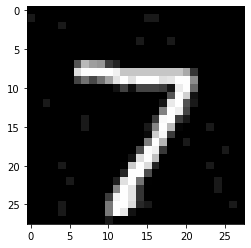

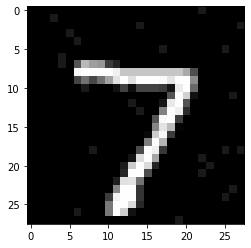

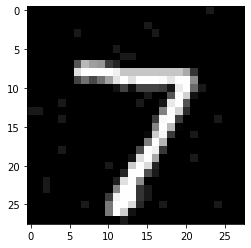

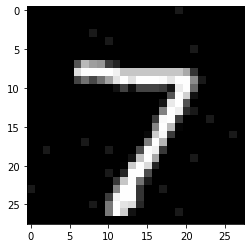

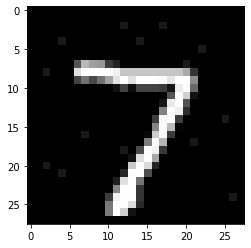

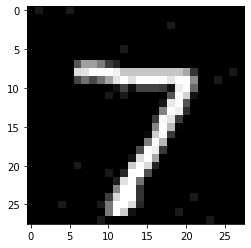

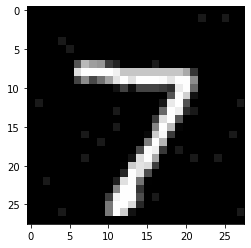

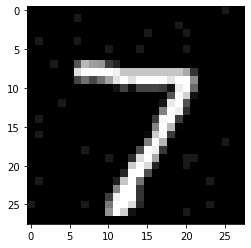

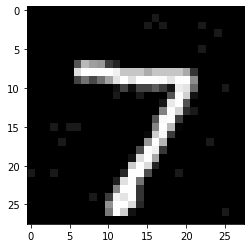

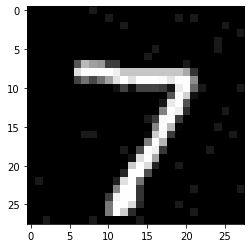

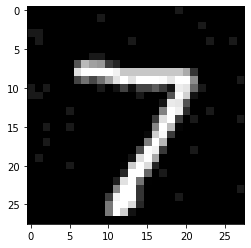

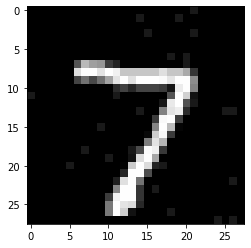

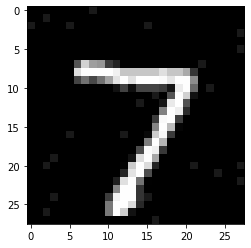

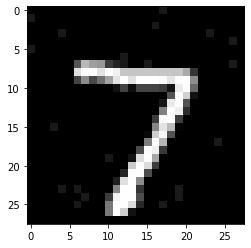

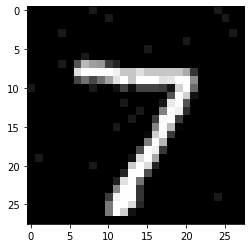

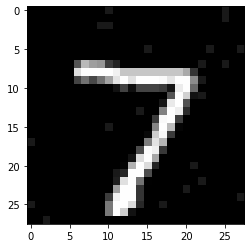

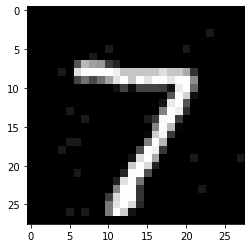

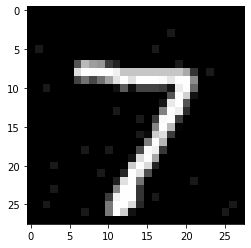

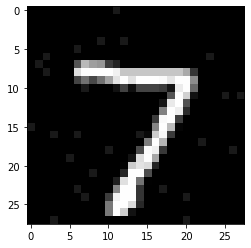

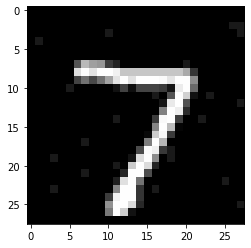

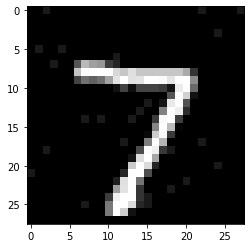

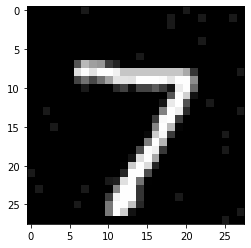

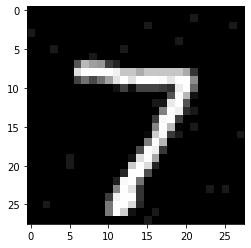

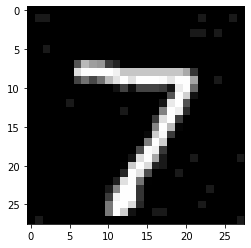

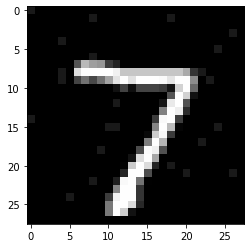

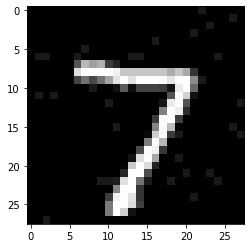

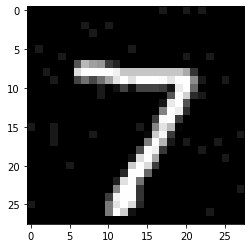

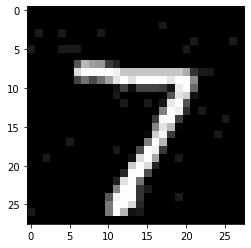

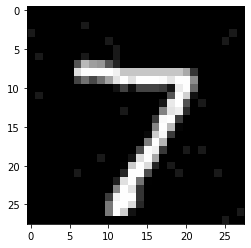

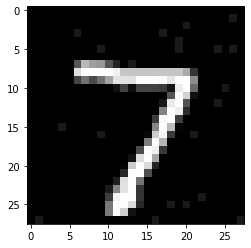

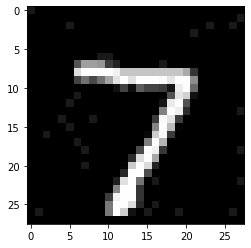

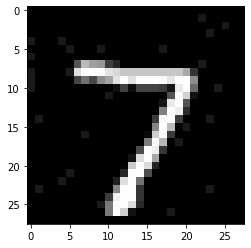

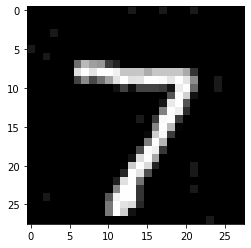

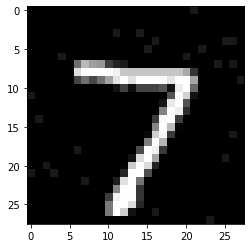

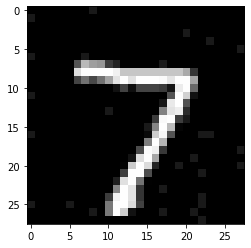

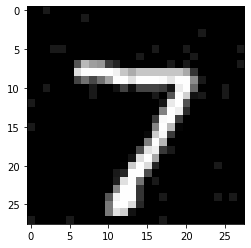

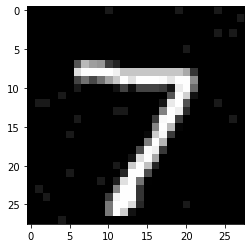

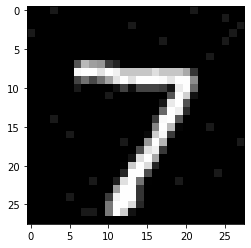

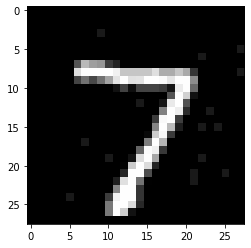

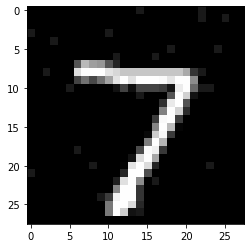

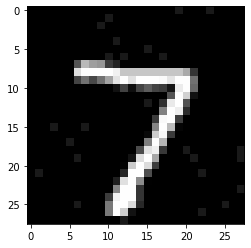

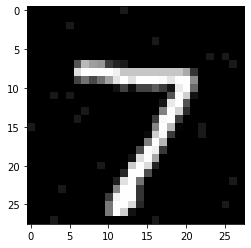

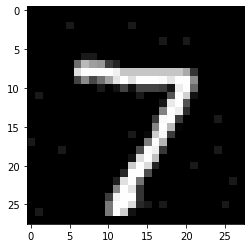

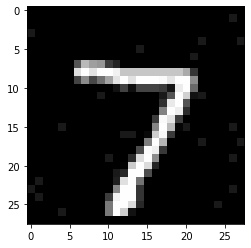

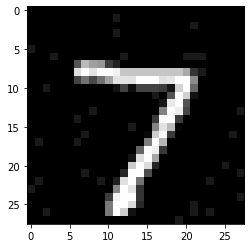

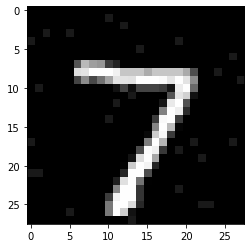

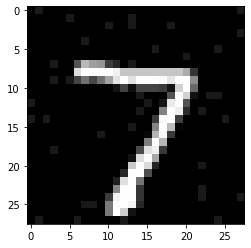

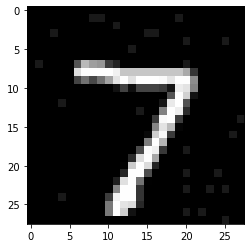

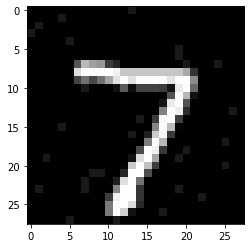

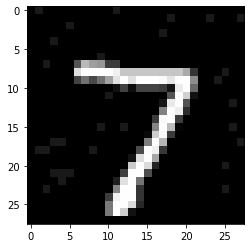

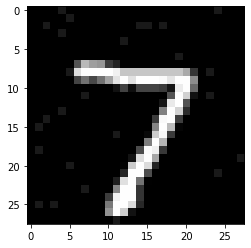

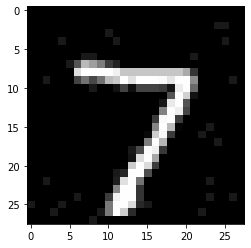

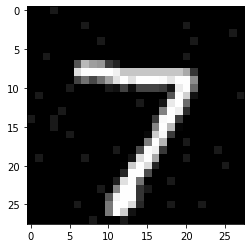

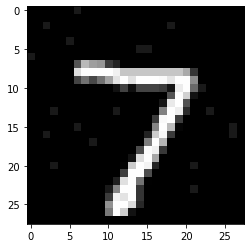

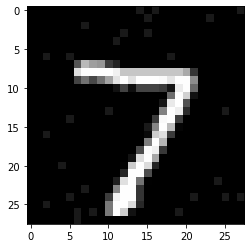

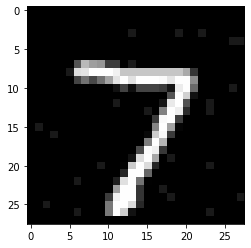

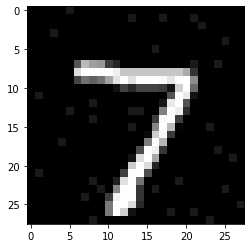

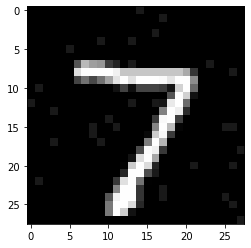

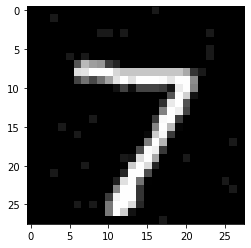

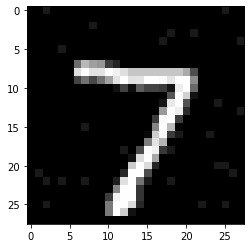

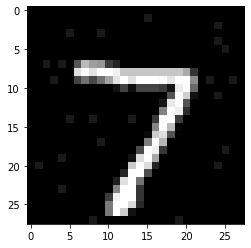

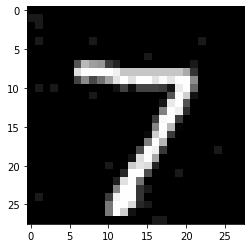

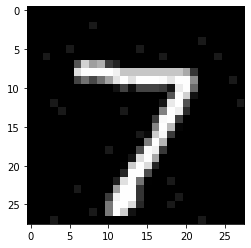

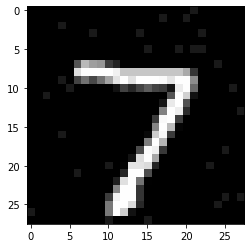

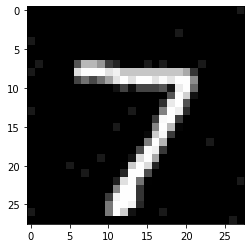

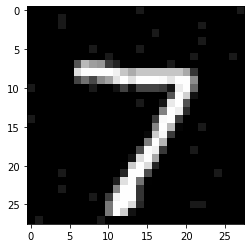

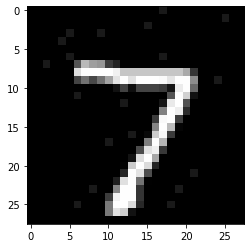

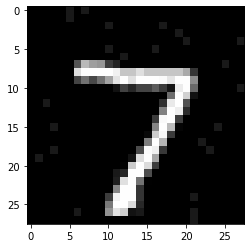

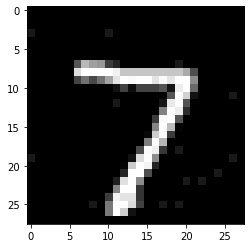

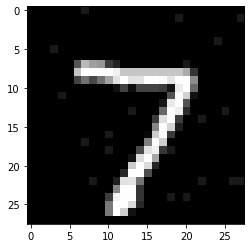

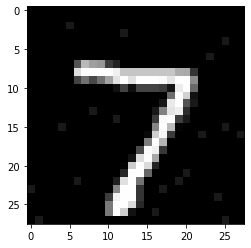

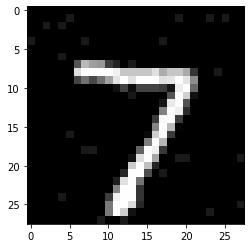

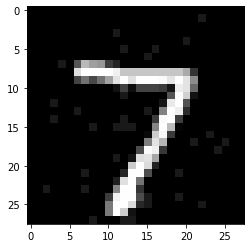

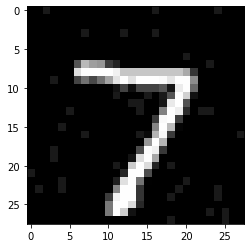

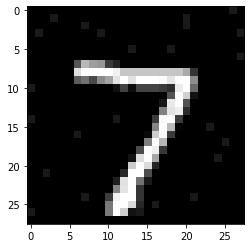

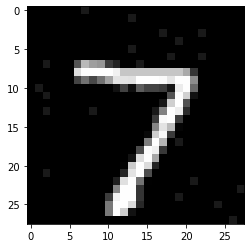

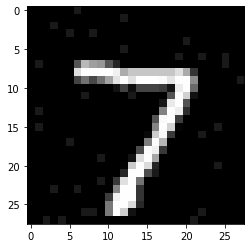

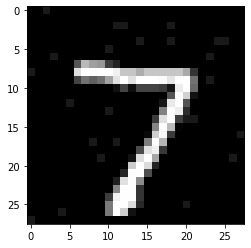

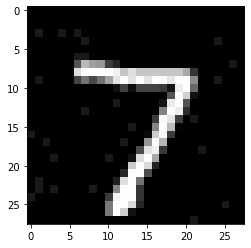

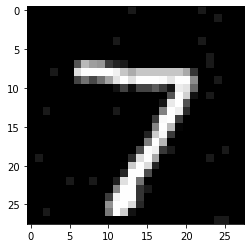

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [5]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [6]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [7]:
x_train = x_train / 255
x_test = x_test / 255 

In [8]:
model = load_model('mnist_model.h5')

In [9]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [10]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [11]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        while GENERATION < MAX_GENERATION: 
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            
            
            if Func(BEST_X) <= F:
                print("resume")
                D += 0.5 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        while GENERATION < MAX_GENERATION:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            
            
            if Dis(BEST_X) <= D:
                print("attack")
                F -= 0.1
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [12]:
MAX_GENERATION = 500  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.8   #置信度参数
D = 3.0   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "attack")
re = Re(cond, "resume")

GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()
if GENERATION == MAX_GENERATION:
    BEST_F = BEST_X+x_test[0]
    #print(BEST_X_F)
    plt.imshow(BEST_F.reshape(28,28),cmap='gray')
    plt.show()
    #break

attack
最优值： 0.99666107 扰动程度： 0.3628384807996926 代数： 1
最优值： 0.9965121 扰动程度： 0.2918371639984623 代数： 2
最优值： 0.9964876 扰动程度： 0.3041770250365246 代数： 3
最优值： 0.9964024 扰动程度： 0.2967082957016534 代数： 4
最优值： 0.9962412 扰动程度： 0.37635261079584803 代数： 5
最优值： 0.99616075 扰动程度： 0.3773608325665342 代数： 6
最优值： 0.9960998 扰动程度： 0.3158714053941105 代数： 7
最优值： 0.9959847 扰动程度： 0.41176084147111197 代数： 8
最优值： 0.99588805 扰动程度： 0.3752764436393047 代数： 9
最优值： 0.99569196 扰动程度： 0.40269797467358176 代数： 10
最优值： 0.9955362 扰动程度： 0.4214178906407763 代数： 11
最优值： 0.99549425 扰动程度： 0.4304295670813395 代数： 12
最优值： 0.99546945 扰动程度： 0.4176275735198515 代数： 13
最优值： 0.99536526 扰动程度： 0.39747983982186164 代数： 14
最优值： 0.9953053 扰动程度： 0.41069859912555506 代数： 15
最优值： 0.9948867 扰动程度： 0.4715633449693692 代数： 16
最优值： 0.9947878 扰动程度： 0.44117227552409133 代数： 17
最优值： 0.9947831 扰动程度： 0.44851041454210483 代数： 18
最优值： 0.9947519 扰动程度： 0.5168385637733323 代数： 19
最优值： 0.9943538 扰动程度： 0.51490748702745 代数： 20
最优值： 0.99416405 扰动程度： 0.5690357275697278 代数： 21
最优

最优值： 0.8246985 扰动程度： 4.3776962862223705 代数： 174
最优值： 0.8306289 扰动程度： 4.3131052124595834 代数： 175
最优值： 0.8385525 扰动程度： 4.269252215200439 代数： 176
最优值： 0.8443258 扰动程度： 4.202813408272407 代数： 177
最优值： 0.8524653 扰动程度： 4.059486106102348 代数： 178
最优值： 0.8550728 扰动程度： 4.0445542345695005 代数： 179
最优值： 0.86027884 扰动程度： 3.9816392151016657 代数： 180
最优值： 0.86287665 扰动程度： 3.9406312867337077 代数： 181
最优值： 0.8687282 扰动程度： 3.859498041866527 代数： 182
最优值： 0.87332964 扰动程度： 3.7409873564449505 代数： 183
最优值： 0.87302136 扰动程度： 3.7393064449820463 代数： 184
最优值： 0.8783158 扰动程度： 3.6494733910449084 代数： 185
最优值： 0.8793167 扰动程度： 3.610857922797214 代数： 186
最优值： 0.87840784 扰动程度： 3.627535770504056 代数： 187
最优值： 0.88013566 扰动程度： 3.5930546887095147 代数： 188
最优值： 0.88093716 扰动程度： 3.585003316961124 代数： 189
最优值： 0.8861419 扰动程度： 3.5092052616852554 代数： 190
最优值： 0.89540535 扰动程度： 3.4395035555070343 代数： 191
attack
最优值： 0.881892 扰动程度： 3.487463082352678 代数： 192
最优值： 0.88046783 扰动程度： 3.5121435414617066 代数： 193
最优值： 0.88014257 扰动程度： 3.522403238

最优值： 0.6619623 扰动程度： 5.493375344148311 代数： 346
最优值： 0.66520184 扰动程度： 5.459166772684551 代数： 347
最优值： 0.6676411 扰动程度： 5.451142099398695 代数： 348
最优值： 0.6606514 扰动程度： 5.419897206489044 代数： 349
最优值： 0.66854274 扰动程度： 5.394738236647975 代数： 350
最优值： 0.6785206 扰动程度： 5.316662970299947 代数： 351
最优值： 0.68720174 扰动程度： 5.1785076850172125 代数： 352
最优值： 0.6875463 扰动程度： 5.190248195384702 代数： 353
最优值： 0.6967421 扰动程度： 5.048544154120987 代数： 354
最优值： 0.70653725 扰动程度： 4.939508564184398 代数： 355
最优值： 0.71029747 扰动程度： 4.916303500199162 代数： 356
最优值： 0.71029747 扰动程度： 4.916303500199162 代数： 357
最优值： 0.7160538 扰动程度： 4.903760840820712 代数： 358
最优值： 0.7227387 扰动程度： 4.881173531750728 代数： 359
最优值： 0.73006946 扰动程度： 4.798250987619822 代数： 360
最优值： 0.73370284 扰动程度： 4.738886164171017 代数： 361
最优值： 0.7297423 扰动程度： 4.722174634443474 代数： 362
最优值： 0.73649985 扰动程度： 4.673558923044055 代数： 363
最优值： 0.74621266 扰动程度： 4.517124013340333 代数： 364
最优值： 0.74726933 扰动程度： 4.516289698954482 代数： 365
最优值： 0.7479501 扰动程度： 4.513466622742379 代数： 366
最

In [13]:
BEST_X

array([ 1.05608929e-05,  1.03589056e-02,  1.62806802e-02,  0.00000000e+00,
        1.72053146e-03,  0.00000000e+00,  0.00000000e+00,  1.72151494e-03,
       -0.00000000e+00,  1.61350334e-02,  0.00000000e+00,  1.78820534e-02,
        0.00000000e+00,  0.00000000e+00,  1.35631452e-01,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  5.24906612e-04,  1.72983485e-02,  0.00000000e+00,
        2.93147783e-07,  0.00000000e+00,  0.00000000e+00,  7.98283847e-04,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.29955742e-03,  0.00000000e+00,  1.15050450e-02,
        6.59421807e-05,  0.00000000e+00,  1.56992638e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.19656176e-02,
        8.05764816e-06,  0.00000000e+00, -0.00000000e+00,  2.21788881e-05,
        6.12060943e-04,  1.40837031e-01,  9.03529593e-05,  1.32127910e-03,
        0.00000000e+00, -

In [21]:
BEST_F

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09803922, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09803922, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09803922,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09803922, 0.        ,
       0.        , 0.        , 0.        , 0.09803922, 0.     

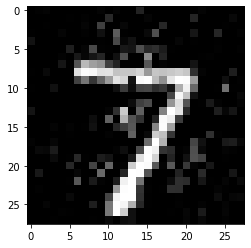

In [14]:
BEST = BEST_X + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [23]:
result=model.predict(BEST_X.reshape(1,784))
result[0]

array([0.03606191, 0.13325453, 0.30351505, 0.14268604, 0.03217717,
       0.18159828, 0.06348677, 0.01640903, 0.07245255, 0.01835869],
      dtype=float32)

In [14]:
# test
count = 0
for i in range(784):
    if BEST_X[i] != 0:
        count+=1
print(count)

448


In [15]:
# test
count = 0
for i in range(784):
    if BEST_X[i] > 0.8:
        count+=1
print(count)

4


In [55]:
V=[1.175,0.8,1.5,1.32,1.912]
for i in range(5):
                    if V[i] > 1:
                        V[i] =1-(V[i]-1)
                       
V = [round(i,3) for i in V]
V

[0.825, 0.8, 0.5, 0.68, 0.088]